# HA Fiscal meets HANK and SAM

By William Du (wdu9@jhu.edu)

 This notebook solves a HANK and SAM model where the household block follows the HA-Fiscal households closely.

 This notebook will solve and illustrate the impulse responses to a:

 - UI extension
  - A cut to the tax rate
  - An increase in transfers (that is proportional to your permanent income)




In [1]:
# import necessary libraries
import numpy as np
from copy import deepcopy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time
from HARK.utilities import make_figs

/opt/anaconda3/envs/HA-Fiscal-temp/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


# Calibrate job transition probabilities

In [2]:



job_find = 2/3 # job finding probability
EU_prob = 0.0306834 # EU probability
job_sep = EU_prob/ (1- job_find) # job separation rate


markov_array_ss = np.array([[ 1 - job_sep*(1 - job_find ), job_find, job_find, job_find , job_find , job_find],
       [job_sep*(1-job_find) , 0.        , 0.        , 0 ,  0, 0       ],
       [0.        , (1-job_find), 0.        , 0.  , 0.        , 0.       ],
       [0.        , 0, (1-job_find)        , 0.  , 0.        , 0.       ],
       [0.        , 0, 0.        , (1-job_find)  , 0.        , 0.       ],

       [0.        , 0. , 0 , 0       , (1-job_find), (1-job_find)]  ])

mrkv_temp_for_will =markov_array_ss

num_mrkv = len(markov_array_ss)

eigen, ss_dstn = sp.linalg.eigs(mrkv_temp_for_will , k=1, which='LM') # get steady state distribution over (un)employment states


ss_dstn = ss_dstn[:,0] / np.sum(ss_dstn[:,0]) # Steady state distribution of employed/unemployed 

ss_dstn = ss_dstn.real

U_ss = (1-ss_dstn[0]) # steady state unemployment

N_ss = ss_dstn[0] # steady state employment



# Compute Unemployment Rate Jacobian

In [3]:
# jacobians for unemployment rate

def create_matrix_U(dx):
    
    job_find_dx = job_find + dx

    markov_array = np.array([[ 1 - job_sep*(1 - job_find_dx ), job_find_dx, job_find_dx, job_find_dx , job_find_dx , job_find_dx],
           [job_sep*(1-job_find_dx) , 0.        , 0.        , 0 ,  0, 0       ],
           [0.        , (1-job_find_dx), 0.        , 0.  , 0.        , 0.       ],
           [0.        , 0, (1-job_find_dx)        , 0.  , 0.        , 0.       ],
           [0.        , 0, 0.        , (1-job_find_dx)  , 0.        , 0.       ],

           [0.        , 0. , 0 , 0       , (1-job_find_dx), (1-job_find_dx)]  ])


    return markov_array

dx = 0.0001


dstn = ss_dstn

bigT = 300 # dimension of jacobian matrix, bigT x bigT
UJAC = np.zeros((num_mrkv,bigT,bigT))

for s in range(bigT):
    for i in range(bigT):
        if i ==s:
            
            tranmat = create_matrix_U(dx)
        
            dstn = np.dot(tranmat,dstn)
    
        else:
            dstn = np.dot(mrkv_temp_for_will,dstn)
    
        UJAC[:,i,s] = (dstn - ss_dstn) / dx


# Calibration for General equilibrium parameters

In [4]:
# Calibrating General Equilibrium parameters

# matching elasticity
alpha = .65

# vacancy filling probability
phi_ss = .71 

#Steady State vacancies
v_ss = N_ss*job_sep / phi_ss


unemployed_searchers = (ss_dstn[1] + ss_dstn[2] + ss_dstn[3]+ ss_dstn[4]+ ss_dstn[5]) 

# job searcher mass
seachers = unemployed_searchers + N_ss*job_sep

# Steady state labor market tightness
theta_ss = v_ss/seachers

# matching efficiency
chi_ss = (phi_ss**(1/-alpha) /theta_ss)**(-alpha)

# job finding probabilty economy wide
eta_ss  = chi_ss * theta_ss**(1-alpha) 


R = 1.01 # real interest rate
r_ss = R - 1 

C_ss_sim  = 0.6910496136078721  # steady state consumption
C_ss = C_ss_sim

A_ss_sim = 1.4324029855872642 # steady state assets
A_ss = A_ss_sim


delta = ((R**4)*(1-(1/5)) )**(1/4) # decay of long term government bonds

qb_ss = (1) / (R - delta) # real price of bonds

B_ss = A_ss/qb_ss # steady state level of bonds

wage_ss = 1.0 # steady state wage (normalized to one)


inc_ui_exhaust = 0.5 # proportion of income of the unemployed who have exhausted UI
tau_ss = 0.3 # steady state tax rate
UI = 0.5*(1-tau_ss)*wage_ss # Effective Unemployment insurance

# private/passive spousal income
Y_priv = inc_ui_exhaust*(1-tau_ss)*wage_ss*( ss_dstn[3] + ss_dstn[4]  +  ss_dstn[5]  ) + (.7-.5)*(1-tau_ss)*wage_ss*(ss_dstn[1] + ss_dstn[2] ) #+ wage_ss*(1-tau_ss)*(inc_ui_exhaust -  0.13)*( mean_human_capital_u[3] +mean_human_capital_u[6]+mean_human_capital_u[7])

# Steady state government consumption
G_ss = tau_ss*wage_ss*ss_dstn[0] - ( UI*(ss_dstn[1] + ss_dstn[2]  )    + ( 1 + delta*qb_ss)*B_ss - qb_ss*B_ss )   # steady state government spending


kappa = .07*(wage_ss*phi_ss) # vacancy posting cost is 7% of the real wage.
HC_ss =  ( ( kappa/phi_ss) * ( 1 - (1/R)*(1-job_sep) )  + wage_ss ) # Steady State hiring cost 

epsilon_p = 6 # elasticity of substitution ( for the goods of intermediate firms who are monopolistically competitive)


MC_ss = (epsilon_p - 1) /epsilon_p # steady state marginal cost
 
Z_ss = HC_ss/MC_ss # Steady State TFP

Y_ss = Z_ss*N_ss # output


#Steady state inflation
pi_ss = 0.0 
varphi = 96.9 # price adjustment cost
#kappa_p_ss = epsilon_p/varphi # slope of phillips curve




# Parameters to be tuned in dashboard

In [5]:
#Policy
phi_pi = 1.5 # taylor rule coefficient on inflation
phi_y = 0.0 # taylor rule coefficient on output

rho_r = 0.0 # inertia of taylor rule
kappa_p_ss = 0.06191950464396284 # slope of Phillips curve ( between 0 and 1)

print('slope of phillips curve', kappa_p_ss)

phi_b = .015 # Speed of fiscal adjustment

real_wage_rigidity =  0.837 # between 0 and 1

# Fiscal Policy parameters
UI_extension_length = 4 # number of quarters the 2 quarter UI extension policy is upheld 
stimulus_check_length = 1 # number of quarters where households receive stimulus checks
tax_cut_length = 8 # number of quarters where taxes are cut/lower


slope of phillips curve 0.06191950464396284


# Specify General Equilibrium Blocks

In [6]:

import sequence_jacobian as sj
from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from matplotlib.pyplot import figure

@sj.simple
def unemployment1(U1,U2,U3, U4, U5) :
    
    U = U1 + U2 + U3 + U4 + U5
    
    return U

@sj.simple
def marginal_cost(HC,Z):
    
    MC =  HC/Z
    return MC


@sj.solved(unknowns={'HC': (-10, 10.0)}, targets=['HC_resid'], solver="brentq")
def hiring_cost(HC,Z,phi,job_sep,r_ante,w):
    
    
    HC_resid = HC - (  ( w  + (kappa/(phi)) - (1/ (1 + r_ante ) )*(1-job_sep) *( kappa/( phi(+1))     )))

    return HC_resid



phi_w = 1.0

@sj.solved(unknowns={'w': (-10, 10.0)}, targets=['wage_resid'], solver="brentq")
def wage_(w,N,phi_w):
    
    wage_resid =( w/wage_ss).apply(np.log) - ( phi_w* (w(-1)/wage_ss).apply(np.log) +  (1 - phi_w)*(N/N_ss).apply(np.log)  )
    return wage_resid






@sj.solved(unknowns={'pi': (-0.1, 0.1)}, targets=['nkpc_resid'], solver="brentq")
def Phillips_Curve(pi,MC,Y,r_ante,kappa_p):

    nkpc_resid =  (1+pi).apply(np.log) - (  kappa_p*(MC-MC_ss) +  (1/ (1 + r_ante ) ) *(Y(+1)/Y) * (1 + pi(+1) ).apply(np.log) )

    return nkpc_resid



@sj.solved(unknowns={'i': (-.5, 0.4)}, targets=['taylor_resid'], solver="brentq")
def taylor(i,pi,Y,ev,rho_r,phi_y,phi_pi):
    taylor_resid = i - rho_r*i(-1) - (1-rho_r)*( phi_pi*pi + phi_y*Y ) - ev
    return taylor_resid


@sj.solved(unknowns={'i': (-.5, 0.4)}, targets=['taylor_resid'], solver="brentq")
def taylor_lagged(i,pi,Y,ev,rho_r,phi_y,phi_pi,lag):
    taylor_resid = i - rho_r*i(-1) - (1-rho_r)*( phi_pi*pi(-lag) + phi_y*Y(-lag)) - ev
                                                
    return taylor_resid



@sj.simple
def matching(theta,chi):
    
    eta  = chi * theta**(1-alpha)
    
    phi = chi * theta**(-alpha)

    
    
    return eta,phi
    



@sj.solved(unknowns={'B': (0.0, 10)}, targets=['fiscal_resid'], solver="brentq")
def fiscal(B,N,qb,G,  w,v,pi,phi_b, UI, U1, U2, U3 , U4, transfers,UI_extend, deficit_T,UI_rr):
    
    
    
    fiscal_resid = (1 + delta*qb)*B(-1) + G + transfers +  UI *(U1 + U2  )  + UI_rr*wage_ss*(1-tau_ss)*(U1 + U2  ) + UI_extend*wage_ss*(1-tau_ss)*(U3 + U4)  +  - qb*B - (tau_ss +phi_b*qb_ss*(B(deficit_T)-B_ss)/Y_ss)*w*N

    #UI_extension_cost = UI_extend*(U3 + U4)

    UI_extension_cost  =UI_extend*wage_ss*(1-tau_ss)*(U3 + U4)

    UI_rr_cost =   UI_rr*wage_ss*(1-tau_ss)*(U1 + U2  )

    debt = qb*B

    return fiscal_resid,UI_extension_cost,debt,UI_rr_cost






@sj.simple
def fiscal_rule(B,phi_b,deficit_T):
    
    tau = tau_ss + phi_b*qb_ss*(B(deficit_T)-B_ss)/Y_ss
    
    return tau



@sj.solved(unknowns={'B': (0.0, 10)}, targets=['fiscal_resid'], solver="brentq")
def fiscal_G(B,N,qb,  w,v,pi, UI, U1, U2, transfers, phi_G,tau,deficit_T):
    
    fiscal_resid = (1 + delta*qb)*B(-1) + G_ss + phi_G*qb_ss*(B(deficit_T)-B_ss)/Y_ss + transfers +  UI *(U1 + U2  )  +  - qb*B - (tau)*w*N

    tax_cost = (tau)*1.0*N_ss

    #tax_cost = (tau)*w*N


    return fiscal_resid,tax_cost



@sj.simple
def fiscal_rule_G(B,phi_G,deficit_T):
    
    G = G_ss + phi_G*qb_ss*(B(deficit_T)-B_ss)/Y_ss
    
    return G



@sj.simple
def production(Z,N):
    Y  = Z*N
    return Y


@sj.simple
def ex_post_longbonds_rate(qb):
    
    r = (1 + delta * qb)/qb(-1) - 1

    return r


@sj.solved(unknowns={'qb': (0.1, 30.0)}, targets=['lbp_resid'], solver="brentq")
def longbonds_price(qb, r_ante):
    lbp_resid = qb - (1 + delta * qb(+1) )/ (1 + r_ante)
    return lbp_resid

@sj.simple
def vacancies(N,phi,job_sep):
    
    v = (N - (1-job_sep(-1))*N(-1))/phi
    
    return v


@sj.simple
def mkt_clearing( C ,G,A,qb,B,w,N,U1,U2,U3, U4, U5):
    

    Y_priv = (1-tau_ss)*wage_ss*.5*  (U3 + U4 + U5)  + (1-tau_ss)*wage_ss*.2*(U1 + U2)

    goods_mkt = C + G - w*N  - Y_priv 
    
    asset_mkt = A  - qb*B

    return goods_mkt, asset_mkt,Y_priv



@sj.simple
def fisher_clearing(r_ante,pi,i):
    
    fisher_resid = 1 + r_ante - ((1+i)/(1+pi(+1))) 
    
    return fisher_resid




In [7]:





@sj.simple
def fisher_clearing_fixed_real_rate(pi):
    """
    fisher_resid = 1 + r_ss - ((1+i)/(1+pi(+1))) 
    """
    i = ( 1 + pi(+1) ) * (1 + r_ss ) - 1
    return i

@sj.solved(unknowns={'B': (0.0, 10)}, targets=['fiscal_resid'], solver="brentq")
def fiscal_fixed_real_rate(B,N,G,  w,v,pi,phi_b, UI, U1, U2, U3 , U4, transfers,UI_extend, deficit_T,UI_rr):
    
    fiscal_resid = (1 + delta*qb_ss)*B(-1) + G + transfers +  UI *(U1 + U2  )  + UI_rr*wage_ss*(1-tau_ss)*(U1 + U2  ) + UI_extend*wage_ss*(1-tau_ss)*(U3 + U4)  +  - qb_ss*B - (tau_ss +phi_b*qb_ss*(B(deficit_T)-B_ss)/Y_ss)*w*N

    UI_extension_cost  = UI_extend*wage_ss*(1-tau_ss)*(U3 + U4) 

    UI_rr_cost =   UI_rr*wage_ss*(1-tau_ss)*(U1 + U2  )


    return fiscal_resid,UI_extension_cost,UI_rr_cost


@sj.solved(unknowns={'B': (0.0, 10)}, targets=['fiscal_resid'], solver="brentq")
def fiscal_G_fixed_real_rate(B,N,  w,v,pi, UI, U1, U2, transfers, phi_G,tau,deficit_T):
    
    fiscal_resid = (1 + delta*qb_ss)*B(-1) + G_ss + phi_G*qb_ss*(B(deficit_T)-B_ss)/Y_ss + transfers +  UI *(U1 + U2  )  +  - qb_ss*B - (tau)*w*N
    tax_cost = (tau)*1.0*N_ss


    return fiscal_resid,tax_cost


# Define steady state dictionary

In [8]:

# define steady state dictionary

SteadyState_Dict = SteadyStateDict({ "asset_mkt":0.0,
                                         "goods_mkt":0.0,
                                    "arg_fisher_resid":0.0,
                                    "lbp_resid": 0.0,
                                    "fiscal_resid":0.0,
                                    "labor_evo_resid": 0.0,
                                    "taylor_resid": 0.0,
                                    "nkpc_resid": 0.0,
                                    
                                    "epsilon_p": epsilon_p,
                                    "U": (1-N_ss),
                                    "U1": ss_dstn[1],
                                    "U2": ss_dstn[2],
                                    "U3": ss_dstn[3],
                                    "U4": ss_dstn[4],
                                    "U5": ss_dstn[5],

                                    "HC": MC_ss*Z_ss,
                        
                                    "MC": MC_ss,
                                    "C": C_ss_sim,
                                    "r": r_ss, 
                                    "r_ante": r_ss,
                                    "Y": Y_ss,
                                    "B":B_ss, 
                                    "G":G_ss, 
                                    "A": A_ss_sim, 
                                    "tau": tau_ss,
                                    "eta": eta_ss,
                                    "phi_b": phi_b,
                                    "phi_w":phi_w,

                                    
                                    "N": N_ss,
                                    
                                    "phi": phi_ss,
                                    "v": v_ss,
                                    "ev": 0.0,
                                    "Z": Z_ss,
                                    "job_sep": job_sep,
                                    "w":wage_ss,
                                    "pi":pi_ss,
                                    "i": r_ss,
                                    "qb": qb_ss,
          
            
                                    "varphi":varphi,
                                    "rho_r": rho_r,
                                    "kappa_p":kappa_p_ss,
                                    "phi_pi": phi_pi,
                                    "phi_y": phi_y,
                                    
                                    "chi": chi_ss,
                                    "theta": theta_ss,
                                    "UI" : UI,
                                    "transfers": 0.0,
                                    "UI_extend": 0.0,
                                    "deficit_T": -1,
                                    "UI_extension_cost" : 0.0,
                                    "UI_rr": 0.0,
                                    "debt": qb_ss*B_ss,
                                    "tax_cost": tau_ss*wage_ss*N_ss,

                                    "lag": -1
                       
                             })



# Import pre-computed Jacobians from pickle files

In [9]:

import pickle # Import Jacobians


obj = open('Code/HA-Models/FromPandemicCode/HA_Fiscal_Jacs.obj', 'rb')
HA_fiscal_JAC = pickle.load(obj)
obj.close()

# main jacobians for aggregate consumption and aggregate assets
Jacobian_Dict = JacobianDict( { 'C' : HA_fiscal_JAC['C'] ,
                                    
                                  'A' : HA_fiscal_JAC['A'] } )

CJACs_by_educ = HA_fiscal_JAC['C_by_educ']
AJACs_by_educ = HA_fiscal_JAC['A_by_educ']



obj = open('Code/HA-Models/FromPandemicCode/HA_Fiscal_Jacs_UI_extend_real.obj', 'rb')
UI_extend_realized_Jacs= pickle.load(obj)
obj.close()


Jacobian_Dict_UI_extend_real = deepcopy(JacobianDict( { 'C' : HA_fiscal_JAC['C'] ,
                                    
                                  'A' : HA_fiscal_JAC['A'] } ))

Jacobian_Dict_UI_extend_real['C']['UI_extend'] = UI_extend_realized_Jacs['C']['UI_extend_real']
Jacobian_Dict_UI_extend_real['A']['UI_extend'] = UI_extend_realized_Jacs['A']['UI_extend_real']



Jacobian_Dict_by_educ = JacobianDict( { 'C_dropout' :CJACs_by_educ['dropout'] ,
                               'C_highschool':CJACs_by_educ['highschool'] ,
                               'C_college' :CJACs_by_educ['college'],
                                    
                                  'A_dropout' : AJACs_by_educ['dropout'] ,
                               'A_highschool' : AJACs_by_educ['highschool'] ,
                               'A_college' : AJACs_by_educ['college']  } )


# (Un)employment rate Jacobians
UJAC_dict = JacobianDict( {    'N': {'eta': UJAC[0]},

    'U1': {'eta': UJAC[1]},
    'U2': {'eta': UJAC[2]},
    'U3': {'eta': UJAC[3]},
    'U4': {'eta': UJAC[4]},
    'U5': {'eta': UJAC[5]},})


    

In [10]:
from copy import copy
old_Jacobian_Dict = deepcopy(Jacobian_Dict)
periods = old_Jacobian_Dict['C']['transfers'].shape[0]

do_splurge = True
if do_splurge:
    splurge = 0.3
    # Loop though Jacobians
    for jacobian_input in ['transfers', 'tau', 'UI_extend', 'UI_rr' , 'eta', 'w']:
        # Calculate the present value of the policy announced for time s
        present_value = np.sum((old_Jacobian_Dict['C'][jacobian_input]/R**np.arange(periods)),axis=0)
        # The splurge jacobian consists of spending the value of the policy at the time that the cash arrives
        splurge_jacobian_component = np.diag(present_value*R**np.arange(periods))
        # The total splurge jacobian is a weighted average of the spurge component and the original jacobian
        splurge_jacobian = splurge*splurge_jacobian_component + (1-splurge)*old_Jacobian_Dict['C'][jacobian_input]
        Jacobian_Dict['C'][jacobian_input] = splurge_jacobian
        Jacobian_Dict['A'][jacobian_input] = (1-splurge)*old_Jacobian_Dict['A'][jacobian_input]
                            
            
                           

# Create HANK and SAM models

In [11]:

HANK_SAM = create_model([Jacobian_Dict, 
                         Jacobian_Dict_by_educ,
                          fiscal,
                          longbonds_price,
                          ex_post_longbonds_rate,
                          fiscal_rule,
                          production,
                          matching,
                          taylor,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,

                          fisher_clearing,mkt_clearing], name="HARK_HANK")




HANK_SAM_tax_rate_shock = create_model([Jacobian_Dict, 
                                        Jacobian_Dict_by_educ,
                          fiscal_G,
                          
                          longbonds_price,
                          ex_post_longbonds_rate,
                          fiscal_rule_G,
                          
                          production,
                          matching,
                          taylor,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                    
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,
                          fisher_clearing,mkt_clearing], name="HARK_HANK")

HANK_SAM_lagged_taylor_rule = create_model([Jacobian_Dict, 
                         Jacobian_Dict_by_educ,
                          fiscal,
                          longbonds_price,
                          ex_post_longbonds_rate,
                          fiscal_rule,
                          production,
                          matching,
                          taylor_lagged,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,

                          fisher_clearing,
                          mkt_clearing], name="HARK_HANK")


HANK_SAM_fixed_real_rate = create_model([Jacobian_Dict, 
                         Jacobian_Dict_by_educ,
                          fiscal_fixed_real_rate,
                          #longbonds_price,
                          #ex_post_longbonds_rate,
                          fiscal_rule,
                          production,
                          matching,
                          #taylor_lagged,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,

                          fisher_clearing_fixed_real_rate,
                          mkt_clearing], name="HARK_HANK")

HANK_SAM_fixed_real_rate_UI_extend_real = create_model([Jacobian_Dict_UI_extend_real, 
                         Jacobian_Dict_by_educ,
                          fiscal_fixed_real_rate,
                          #longbonds_price,
                          #ex_post_longbonds_rate,
                          fiscal_rule,
                          production,
                          matching,
                          #taylor_lagged,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,

                          fisher_clearing_fixed_real_rate,
                          mkt_clearing], name="HARK_HANK")



HANK_SAM_tax_cut_fixed_real_rate = create_model([Jacobian_Dict, 
                         Jacobian_Dict_by_educ,
                          fiscal_G_fixed_real_rate,
                          #longbonds_price,
                          #ex_post_longbonds_rate,
                          fiscal_rule_G,
                          production,
                          matching,
                          #taylor_lagged,
                          Phillips_Curve,
                          marginal_cost,
                          UJAC_dict,
                          hiring_cost,
                          wage_,
                          vacancies,
                          
                          unemployment1,

                          fisher_clearing_fixed_real_rate,
                          mkt_clearing], name="HARK_HANK")







# Different stimulus policies

In [12]:
unknowns = ['theta', 'r_ante' ]
targets = ['asset_mkt', 'fisher_resid' ]
targets_goods_mkt = ['asset_mkt', 'fisher_resid' ]

T = bigT


# UI extensions

In [13]:

dUI_extension = np.zeros(bigT)
dUI_extension[:UI_extension_length] = .2 # Income of households with UI 0.7, income of households without UI is 0.5. Income of employed is normalized to 1.0. Note that the jacobian in the code is respect to a perturbation that accounts for wages and taxes. In particular, in the code it is: "+ dx*wage_ss*(1-tau_ss) "
shocks_UI_extension = {'UI_extend': dUI_extension}


SteadyState_Dict_UI_extend = deepcopy(SteadyState_Dict)
SteadyState_Dict_UI_extend['phi_b'] = phi_b #fiscal adjustment parameter
SteadyState_Dict_UI_extend['phi_w'] = real_wage_rigidity #wage ridigity parameter ( if equal to 1.0 than real wage is fixed)
SteadyState_Dict_UI_extend['rho_r'] = rho_r #inertial parameter for taylor rule
SteadyState_Dict_UI_extend['phi_y'] = phi_y #taylor rule coefficient on output
SteadyState_Dict_UI_extend['phi_pi'] = phi_pi #taylor rule coefficient on inflation
SteadyState_Dict_UI_extend['deficit_T'] = -1  #the number of periods it takes for government to adjust and follow its fiscal rule. If equal deficit_T = -40, then government will keep taxes fixed for 40 quarters


SteadyState_Dict_UI_extend_fixed_nominal_rate = deepcopy(SteadyState_Dict_UI_extend)
SteadyState_Dict_UI_extend_fixed_nominal_rate['phi_pi'] = 0.0 # taylor rule does not react to inflation

irfs_UI_extend = HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_extend, unknowns, targets, shocks_UI_extension)
irfs_UI_extend_fixed_nominal_rate = HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_extend_fixed_nominal_rate, unknowns, targets, shocks_UI_extension)



green = 'green'



# Lag in the taylor rule

In [14]:
SteadyState_Dict_UI_extend_lagged_nominal_rate = deepcopy(SteadyState_Dict_UI_extend)

monetary_policy_lag = 2 
SteadyState_Dict_UI_extend_lagged_nominal_rate['lag'] = monetary_policy_lag # number of quarters the fed does not react
irfs_UI_extend_lagged_nominal_rate = HANK_SAM_lagged_taylor_rule.solve_impulse_linear(SteadyState_Dict_UI_extend_lagged_nominal_rate, unknowns, targets, shocks_UI_extension)


## Solve for IRF to UI extension shock under a fixed real rate

In [15]:
unknowns_fixed_real_rate = ['theta' ]
targets_fixed_real_rate = ['asset_mkt' ]

In [16]:

irfs_UI_extension_fixed_real_rate = HANK_SAM_fixed_real_rate.solve_impulse_linear(SteadyState_Dict_UI_extend, unknowns_fixed_real_rate, targets_fixed_real_rate, shocks_UI_extension)  # solve for IRFs



# Multipliers under Fixed real rate

In [17]:
def NPV(irf,length): # to compute Net present value
    
    NPV = 0
    for i in range(length):
        
        NPV +=irf[i]/R**i
        
        
    return NPV

In [18]:
print('multiplier out of 2Q UI extension (active taylor rule)', NPV(irfs_UI_extend['Y'], bigT)/NPV(irfs_UI_extend['UI_extension_cost'],bigT))
print('multiplier out of 2Q UI extension (fixed nominal rate)',NPV(irfs_UI_extend_fixed_nominal_rate['Y'], bigT)/NPV(irfs_UI_extend_fixed_nominal_rate['UI_extension_cost'],bigT))
print('multiplier out of 2Q UI extension (fixed real rate)',NPV(irfs_UI_extension_fixed_real_rate['Y'], bigT)/NPV(irfs_UI_extension_fixed_real_rate['UI_extension_cost'],bigT))



multiplier out of 2Q UI extension (active taylor rule) 0.9885457148980847
multiplier out of 2Q UI extension (fixed nominal rate) 1.2792025293909328
multiplier out of 2Q UI extension (fixed real rate) 1.2271113737124015


In [19]:
irf_UI_extend_realizations = HANK_SAM_fixed_real_rate_UI_extend_real.solve_impulse_linear(SteadyState_Dict_UI_extend, unknowns_fixed_real_rate, targets_fixed_real_rate, shocks_UI_extension)  # solve for IRFs

# Transfers


In [20]:



dtransfers = np.zeros(bigT)
dtransfers[:stimulus_check_length] = C_ss*.05  #Approxiate size of aggregate stimulus check spending 
shocks_transfers = {'transfers': dtransfers}


SteadyState_Dict_transfer = deepcopy(SteadyState_Dict)

SteadyState_Dict_transfer['phi_b'] = phi_b
SteadyState_Dict_transfer['phi_w'] = real_wage_rigidity
SteadyState_Dict_transfer['rho_r'] = rho_r
SteadyState_Dict_transfer['phi_y'] = phi_y
SteadyState_Dict_transfer['phi_pi'] = phi_pi
SteadyState_Dict_transfer['deficit_T'] = -1

SteadyState_Dict_UI_transfer_fixed_nominal_rate = deepcopy(SteadyState_Dict_transfer)
SteadyState_Dict_UI_transfer_fixed_nominal_rate['phi_pi'] = 0.0

irfs_transfer = HANK_SAM.solve_impulse_linear(SteadyState_Dict_transfer, unknowns, targets, shocks_transfers)
irfs_transfer_fixed_nominal_rate = HANK_SAM.solve_impulse_linear(SteadyState_Dict_UI_transfer_fixed_nominal_rate, unknowns, targets, shocks_transfers)





In [21]:
print('multiplier out of transfers', NPV(irfs_transfer['Y'], bigT)/NPV(irfs_transfer['transfers'],bigT))

print('multiplier out of transfers (fixed nominal rate)', NPV(irfs_transfer_fixed_nominal_rate['Y'], bigT)/NPV(irfs_transfer_fixed_nominal_rate['transfers'],bigT))


multiplier out of transfers 0.8879593016300241
multiplier out of transfers (fixed nominal rate) 1.24021812679741


## lagged taylor rule

Fed does not react for a certain number of periods.

In [22]:
SteadyState_Dict_transfers_lagged_nominal_rate = deepcopy(SteadyState_Dict_transfer)

monetary_policy_lag = 2
SteadyState_Dict_transfers_lagged_nominal_rate['lag'] = monetary_policy_lag # number of quarters the fed does not react
irfs_transfers_lagged_nominal_rate = HANK_SAM_lagged_taylor_rule.solve_impulse_linear(SteadyState_Dict_transfers_lagged_nominal_rate, unknowns, targets, shocks_transfers)



## Fixed Real Rate

In [23]:

irfs_transfer_fixed_real_rate = HANK_SAM_fixed_real_rate.solve_impulse_linear(SteadyState_Dict_transfer, unknowns_fixed_real_rate, targets_fixed_real_rate, shocks_transfers)  # solve for IRFs


In [24]:
print('multiplier out of transfers (active taylor rule)', NPV(irfs_transfer['Y'], bigT)/NPV(irfs_transfer['transfers'],bigT))
print('multiplier out of transfers (fixed nominal rate)', NPV(irfs_transfer_fixed_nominal_rate['Y'], bigT)/NPV(irfs_transfer_fixed_nominal_rate['transfers'],bigT))
print('multiplier out of transfers (fixed real rate)'   ,    NPV(irfs_transfer_fixed_real_rate['Y'], bigT)/NPV(irfs_transfer_fixed_real_rate['transfers'],bigT))


multiplier out of transfers (active taylor rule) 0.8879593016300241
multiplier out of transfers (fixed nominal rate) 1.24021812679741
multiplier out of transfers (fixed real rate) 1.181482018832636


# Tax cut

In [25]:


dtau = np.zeros(bigT)
dtau[:tax_cut_length] = -.02
shocks_tau = {'tau': dtau}


SteadyState_Dict_tax_shock = deepcopy(SteadyState_Dict)


SteadyState_Dict_tax_shock['phi_G'] = -phi_b # fiscal adjustment parameter
SteadyState_Dict_tax_shock['phi_w'] = real_wage_rigidity # wage ridigity parameter ( if equal to 1.0 than real wage is fixed)
SteadyState_Dict_tax_shock['rho_r'] = rho_r #inertial parameter for taylor rule
SteadyState_Dict_tax_shock['phi_y'] = phi_y # taylor rule coefficient on output
SteadyState_Dict_tax_shock['phi_pi'] = phi_pi # taylor rule coefficient on inflation
SteadyState_Dict_tax_shock['deficit_T'] = -1 # the number of periods it takes for government to adjust and follow its fiscal rule. 
#If equal to -40, then government will keep taxes fixed for 40 quarters

SteadyState_Dict_tax_shock_fixed_rate= deepcopy(SteadyState_Dict_tax_shock)
SteadyState_Dict_tax_shock_fixed_rate['phi_pi'] = 0.0

irfs_tau = HANK_SAM_tax_rate_shock.solve_impulse_linear(SteadyState_Dict_tax_shock, unknowns, targets, shocks_tau)
irfs_tau_fixed_nominal_rate = HANK_SAM_tax_rate_shock.solve_impulse_linear(SteadyState_Dict_tax_shock_fixed_rate, unknowns, targets, shocks_tau)






In [26]:

irfs_tau_fixed_real_rate = HANK_SAM_tax_cut_fixed_real_rate.solve_impulse_linear(SteadyState_Dict_tax_shock, unknowns_fixed_real_rate, targets_fixed_real_rate, shocks_tau)


In [27]:
print('multiplier out of tax cut', NPV(irfs_tau['Y'], bigT)/NPV(irfs_tau['tax_cost'],bigT))
print('multiplier out of tax cut (fixed real rate)', NPV(irfs_tau_fixed_real_rate['Y'], bigT)/NPV(irfs_tau_fixed_real_rate['tax_cost'],bigT))
print('multiplier out of tax cut (fixed nominal rate)', NPV(irfs_tau_fixed_nominal_rate['Y'], bigT)/NPV(irfs_tau_fixed_nominal_rate['tax_cost'],bigT))


multiplier out of tax cut -0.8416712562056481
multiplier out of tax cut (fixed real rate) -1.1823878622267976
multiplier out of tax cut (fixed nominal rate) -1.267732261529065


# Compute Fiscal Multipliers

This section computes and plots the cumulative fiscal multipliers for each policy from the HANK and SAM model. 

In particular, the code below computes these multipliers under three monetary policies:

- A standard taylor rule that only reacts to inflation.
- A taylor rule that implies a fixed nominal rate.
- A version of the model where the monetary authority adjusts the nominal rate such that the real rate is held fixed. 

In [28]:


horizon_length = 20


multipliers_transfers = np.zeros(horizon_length) # Fiscal multipliers to stimulus check under standard taylor rule
multipliers_UI_extend = np.zeros(horizon_length)  # Fiscal multipliers to 2Q UI extension under fixed nominal rate
multipliers_tax_cut = np.zeros(horizon_length) # Fiscal multipliers to tax cut under standard taylor rule

multipliers_transfers_fixed_nominal_rate = np.zeros(horizon_length) # Fiscal multipliers to stimulus check under fixed nominal rate
multipliers_UI_extensions_fixed_nominal_rate = np.zeros(horizon_length)  # Fiscal multipliers to 2Q UI extension under fixed nominal rate
multipliers_tax_cut_fixed_nominal_rate = np.zeros(horizon_length)  # Fiscal multipliers to tax cut under fixed nominal rate


multipliers_transfers_fixed_real_rate = np.zeros(horizon_length) # Fiscal multipliers to stimulus check under fixed real rate
multipliers_UI_extensions_fixed_real_rate = np.zeros(horizon_length) # Fiscal multipliers to 2Q UI extension under fixed real rate
multipliers_tax_cut_fixed_real_rate = np.zeros(horizon_length)  # Fiscal multipliers to tax cut under fixed real rate

for i in range(horizon_length):

    multipliers_transfers_fixed_nominal_rate[i] =  NPV(irfs_transfer_fixed_nominal_rate['C'], i + 1)/NPV(irfs_transfer_fixed_nominal_rate['transfers'],300)
    multipliers_UI_extensions_fixed_nominal_rate[i] =  NPV(irfs_UI_extend_fixed_nominal_rate['C'], i + 1)/NPV(irfs_UI_extend_fixed_nominal_rate['UI_extension_cost'],300)
    multipliers_tax_cut_fixed_nominal_rate[i] =  -NPV(irfs_tau_fixed_nominal_rate['C'], i + 1)/NPV(irfs_tau_fixed_nominal_rate['tax_cost'],300)

    multipliers_transfers[i] =  NPV(irfs_transfer['C'], i + 1)/NPV(irfs_transfer['transfers'],300)
    multipliers_UI_extend[i] =   NPV(irfs_UI_extend['C'], i + 1)/NPV(irfs_UI_extend['UI_extension_cost'],300)
    multipliers_tax_cut[i] =  -NPV(irfs_tau['C'], i + 1)/NPV(irfs_tau['tax_cost'],300)

    multipliers_transfers_fixed_real_rate[i] =  NPV(irfs_transfer_fixed_real_rate['C'], i + 1)/NPV(irfs_transfer_fixed_real_rate['transfers'],300)
    multipliers_UI_extensions_fixed_real_rate[i] =  NPV(irfs_UI_extension_fixed_real_rate['C'], i + 1)/NPV(irfs_UI_extension_fixed_real_rate['UI_extension_cost'],300)
    multipliers_tax_cut_fixed_real_rate[i] =  -NPV(irfs_tau_fixed_real_rate['C'], i + 1)/NPV(irfs_tau_fixed_real_rate['tax_cost'],300)





# Multipliers across the horizon (standard Taylor rule)

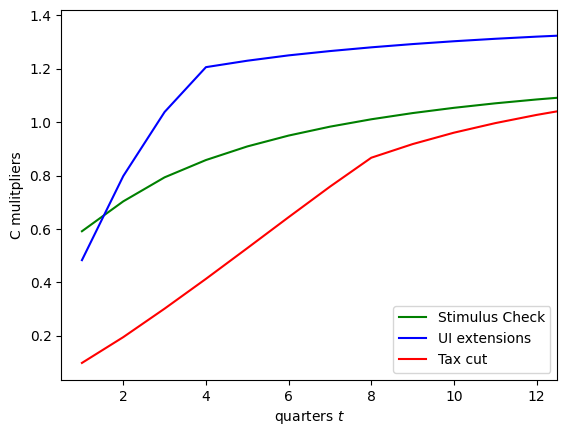

In [29]:
plt.plot(np.arange(horizon_length) +1,multipliers_transfers , label = 'Stimulus Check', color = 'green')
plt.plot(np.arange(horizon_length) +1,multipliers_UI_extend , label = 'UI extensions' , color = 'blue')
plt.plot(np.arange(horizon_length) +1,multipliers_tax_cut , label = 'Tax cut', color = 'red')
plt.legend(loc = 'lower right')
plt.ylabel('C mulitpliers')
plt.xlabel('quarters $t$')
plt.xlim(.5,12.5)
plt.show()

In [30]:

def plot_multipliers_three_experiments(multipliers_transfers,multipliers_transfers_fixed_nominal_rate,multipliers_transfers_fixed_real_rate, 
                                            multipliers_UI_extend,multipliers_UI_extensions_fixed_nominal_rate,multipliers_UI_extensions_fixed_real_rate, 
                                            multipliers_tax_cut,multipliers_tax_cut_fixed_nominal_rate,multipliers_tax_cut_fixed_real_rate):

    green = 'darkorange'
    red = 'red'
    
    Length = len(multipliers_transfers_fixed_nominal_rate) + 1
    fontsize = 10
    width = 2
    label_size = 8
    legend_size = 11
    ticksize = 8
    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    
    y_max1 =  max(multipliers_transfers_fixed_nominal_rate)*1.5
    y_max2 =  max(multipliers_UI_extensions_fixed_real_rate)*1.5
    y_max = max([y_max1,y_max2])
    for i in range(3):
        axs[i].set_ylim(-.2, y_max)
    
    axs[1].plot(np.arange(horizon_length) +1,multipliers_transfers,linewidth= width, label = "Standard Taylor Rule")
    axs[1].plot(np.arange(horizon_length) +1,multipliers_transfers_fixed_nominal_rate,linewidth= width, label = "Fixed Nominal Rate", linestyle = '--', color = green)
    axs[1].plot(np.arange(horizon_length) +1,multipliers_transfers_fixed_real_rate,linewidth= width, label = "Fixed Real " , linestyle = ':', color = red)
    axs[1].set_title("UI Extension",fontdict={'fontsize': fontsize})
    
    
    axs[0].plot(np.arange(horizon_length) +1,multipliers_UI_extend, linewidth= width, label = "Standard Taylor Rule")
    axs[0].plot(np.arange(horizon_length) +1,multipliers_UI_extensions_fixed_nominal_rate,linewidth= width, label = "Fixed Nominal Rate", linestyle = '--', color = green)
    axs[0].plot(np.arange(horizon_length) +1,multipliers_UI_extensions_fixed_real_rate,linewidth= width, label = "Fixed Real " , linestyle = ':', color = red)
    axs[0].set_title("Stimulus Check",fontdict={'fontsize': fontsize})
    axs[0].legend(prop={'size': legend_size},loc='upper left')
    
    axs[2].plot(np.arange(horizon_length) +1,multipliers_tax_cut, linewidth= width, label = "Standard Taylor Rule")
    axs[2].plot(np.arange(horizon_length) +1,multipliers_tax_cut_fixed_nominal_rate,linewidth= width, label = "Fixed Nominal Rate", linestyle = '--', color = green)
    axs[2].plot(np.arange(horizon_length) +1,multipliers_tax_cut_fixed_real_rate,linewidth= width, label = "Fixed Real " , linestyle = ':', color = red)
    axs[2].set_title("Tax Cut",fontdict={'fontsize': fontsize})
    
    for i in range(3):
        axs[i].plot(np.zeros(Length),'k' )
        axs[i].tick_params(axis='both', labelsize=ticksize)
    
        axs[i].set_ylabel('Multipliers', fontsize = label_size)
        axs[i].set_xlabel('Quarters', fontsize = label_size)
        axs[i].locator_params(axis='both', nbins=7) 
        axs[i].grid(alpha=0.3)
    
    fig.tight_layout()

# Multipliers of each policy under various monetary policy rules

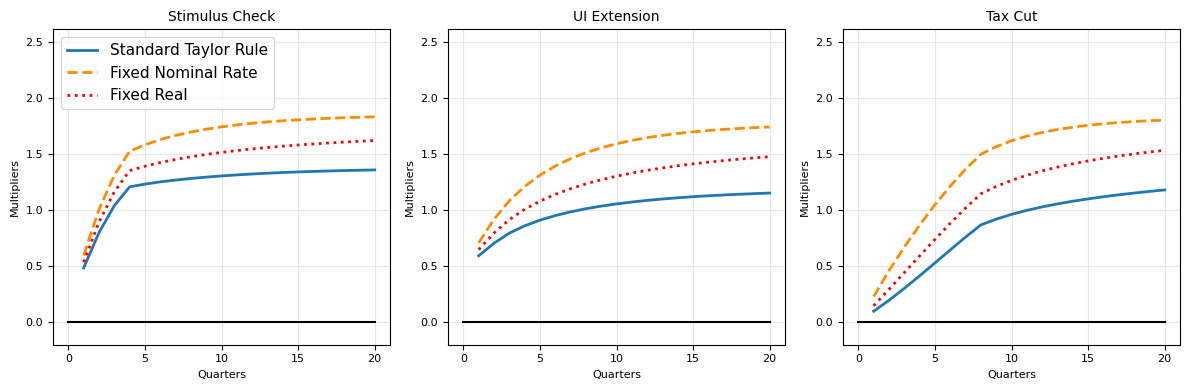

In [31]:
 plot_multipliers_three_experiments(multipliers_transfers,multipliers_transfers_fixed_nominal_rate,multipliers_transfers_fixed_real_rate, 
                                            multipliers_UI_extend,multipliers_UI_extensions_fixed_nominal_rate,multipliers_UI_extensions_fixed_real_rate, 
                                            multipliers_tax_cut,multipliers_tax_cut_fixed_nominal_rate,multipliers_tax_cut_fixed_real_rate)


In [32]:
def plot_consumption_irfs_three_experiments(irf_UI1,irf_UI2,irf_UI3, irf_SC1,irf_SC2,irf_SC3, irf_TC1,irf_TC2,irf_TC3):
    
    green = 'darkorange'
    red = 'red'

    Length = 12
    fontsize = 10
    width = 2
    label_size = 8
    legend_size = 11
    ticksize = 8
    fig, axs = plt.subplots(1, 3, figsize=(12,4))

    y_max1 =  max(100*irf_TC2['C'][:Length]/C_ss)*1.05
    y_max2 =  max(100*irf_SC2['C'][:Length]/C_ss)*1.05
    y_max = max([y_max1,y_max2])
    for i in range(3):
        axs[i].set_ylim(-.2, y_max)

    axs[1].plot(100*irf_UI1['C'][:Length]/C_ss,linewidth= width, label = "Standard Taylor Rule")
    axs[1].plot(100*irf_UI2['C'][:Length]/C_ss,linewidth= width, label = "Fixed Nominal Rate", linestyle = '--', color = green)
    axs[1].plot(100*irf_UI3['C'][:Length]/C_ss,linewidth= width, label = "Fixed Real " , linestyle = ':', color = red)
    axs[1].set_title("UI Extension",fontdict={'fontsize': fontsize})


    axs[0].plot(100*irf_SC1['C'][:Length]/C_ss,linewidth= width, label = "Standard Taylor Rule")
    axs[0].plot(100*irf_SC2['C'][:Length]/C_ss,linewidth= width, label = "Fixed Nominal Rate", linestyle = '--', color = green)
    axs[0].plot(100*irf_SC3['C'][:Length]/C_ss,linewidth= width, label = "Fixed Real " , linestyle = ':', color = red)
    axs[0].set_title("Stimulus Check",fontdict={'fontsize': fontsize})
    axs[0].legend(prop={'size': legend_size})

    axs[2].plot(100*irf_TC1['C'][:Length]/C_ss,linewidth= width, label = "Standard Taylor Rule")
    axs[2].plot(100*irf_TC2['C'][:Length]/C_ss,linewidth= width, label = "Fixed Nominal Rate", linestyle = '--', color = green)
    axs[2].plot(100*irf_TC3['C'][:Length]/C_ss,linewidth= width, label = "Fixed Real " , linestyle = ':', color = red)
    axs[2].set_title("Tax Cut",fontdict={'fontsize': fontsize})

    for i in range(3):
        axs[i].plot(np.zeros(Length),'k' )
        axs[i].tick_params(axis='both', labelsize=ticksize)

        axs[i].set_ylabel('% consumption deviation', fontsize = label_size)
        axs[i].set_xlabel('Quarters', fontsize = label_size)
        axs[i].locator_params(axis='both', nbins=7) 
        axs[i].grid(alpha=0.3)

    fig.tight_layout()

# Consumption response to each policy under various monetary policy rules

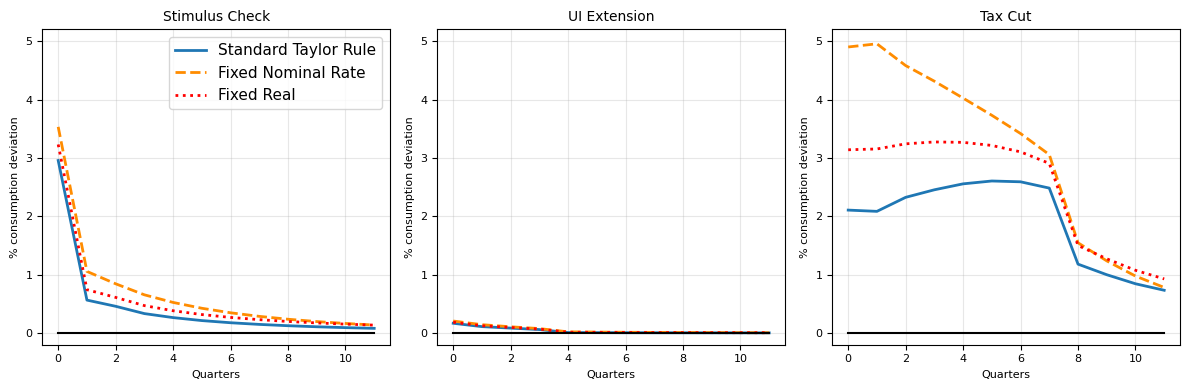

In [33]:

plot_consumption_irfs_three_experiments(irfs_UI_extend,irfs_UI_extend_fixed_nominal_rate,irfs_UI_extension_fixed_real_rate, irfs_transfer,irfs_transfer_fixed_nominal_rate,irfs_transfer_fixed_real_rate, irfs_tau,irfs_tau_fixed_nominal_rate,irfs_tau_fixed_real_rate)
#plt.savefig("figures/HANK_IRFs_w_splurge.pdf")



In [34]:
def plot_consumption_irfs_three(irf_SC1,irf_UI1, irf_TC1):
    
    green = 'darkorange'
    red = 'red'

    Length = 12
    fontsize = 10
    width = 2
    label_size = 8
    legend_size = 8
    ticksize = 8
    fig, axs = plt.subplots(1, 3, figsize=(12,4))

    y_max1 =  max(100*irf_TC1['C'][:Length]/C_ss)*1.05
    y_max2 =  max(100*irf_SC1['C'][:Length]/C_ss)*1.05
    y_max = max([y_max1,y_max2])
    for i in range(3):
        axs[i].set_ylim(-0.1, y_max)

    axs[1].plot(100*irf_UI1['C'][:Length]/C_ss,linewidth= width, label = "Standard Taylor Rule")
    axs[1].set_title("UI Extension",fontdict={'fontsize': fontsize})


    axs[0].plot(100*irf_SC1['C'][:Length]/C_ss,linewidth= width, label = "Standard Taylor Rule")
    axs[0].set_title("Stimulus Check",fontdict={'fontsize': fontsize})
    axs[0].legend(prop={'size': legend_size})

    axs[2].plot(100*irf_TC1['C'][:Length]/C_ss,linewidth= width, label = "Standard Taylor Rule")
    axs[2].set_title("Tax Cut",fontdict={'fontsize': fontsize})

    for i in range(3):
        axs[i].plot(np.zeros(Length),'k' )
        axs[i].tick_params(axis='both', labelsize=ticksize)

        axs[i].set_ylabel('% consumption deviation', fontsize = label_size)
        axs[i].set_xlabel('Quarters', fontsize = label_size)
        axs[i].locator_params(axis='both', nbins=7) 
        axs[i].grid(alpha=0.3)
    fig.tight_layout()

# Consumption response to each fiscal policy under a standard Taylor rule

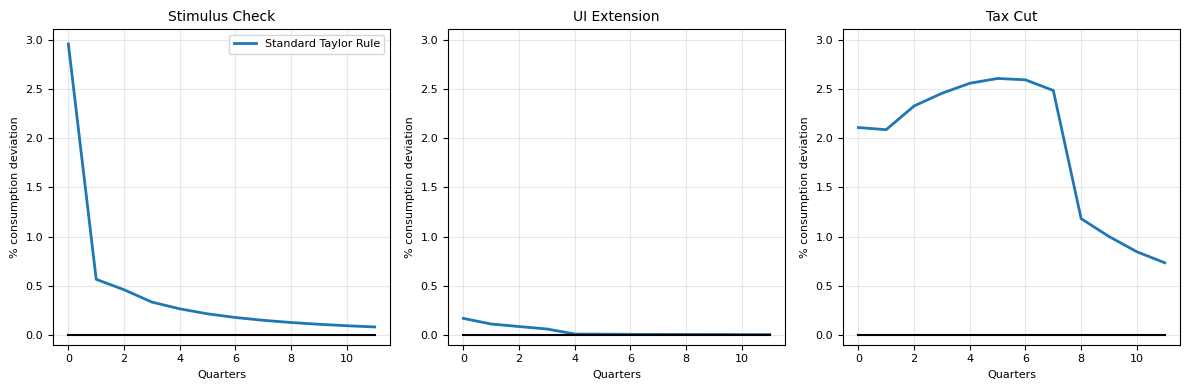

In [35]:
plot_consumption_irfs_three(irfs_transfer, irfs_UI_extend, irfs_tau)

In [36]:
# Make each plot individually to match what Ivan does in the main code
def plot_consumption_irf(irf1, irf2, irf3, y_max, filename, legend = False):
    green = 'darkorange'
    red = 'red'

    Length = 12
    plt.figure(figsize=(4, 4))
    x_axis = np.arange(1,Length+1)

    plt.plot(x_axis,100*irf1['C'][:Length]/C_ss, label="Active Taylor Rule")
    plt.plot(x_axis,100*irf2['C'][:Length]/C_ss, label="Fixed Nominal Rate", linestyle='--', color=green)
    plt.plot(x_axis,100*irf3['C'][:Length]/C_ss, label="Fixed Real", linestyle=':', color=red)

    plt.xticks(np.arange(min(x_axis), max(x_axis)+1, 1.0))
    plt.xlabel('quarter')
    #plt.ylabel('% difference relative to recession')
    #plt.savefig(fig_dir +'recession_taxcut_relrecession.pdf')
    plt.ylim(0, y_max)
    if legend:
        plt.legend(loc='best')
        plt.ylabel('% consumption deviation')
        
    #make_figs(filename, True , False, target_dir=fig_dir) 
    
    plt.show() 

fig_dir = "figures/"
y_max =  max(100*irfs_tau_fixed_nominal_rate['C'][:12]/C_ss)*1.05
plot_consumption_irf( irfs_transfer,irfs_transfer_fixed_nominal_rate,irfs_transfer_fixed_real_rate, y_max, "HANK_transfer_IRF", legend=True)
plot_consumption_irf( irfs_UI_extend,irfs_UI_extend_fixed_nominal_rate,irfs_UI_extension_fixed_real_rate, y_max, "HANK_UI_IRF")
plot_consumption_irf( irfs_tau,irfs_tau_fixed_nominal_rate,irfs_tau_fixed_real_rate, y_max, "HANK_tax_IRF")

In [37]:
# Make each plot individually to match what Ivan does in the main code
def plot_consumption_multipliers(multiplier1, multiplier2, multiplier3, y_max, filename, legend = False):
    green = 'darkorange'
    red = 'red'

    Length = 12
    plt.figure(figsize=(4, 4))
    x_axis = np.arange(1,Length+1)

    plt.plot(x_axis,multiplier1[0:Length], label="Active Taylor Rule")
    plt.plot(x_axis,multiplier2[0:Length], label="Fixed Nominal Rate", linestyle='--', color=green)
    plt.plot(x_axis,multiplier3[0:Length], label="Fixed Real", linestyle=':', color=red)

    plt.xticks(np.arange(min(x_axis), max(x_axis)+1, 1.0))
    plt.xlabel('quarter')
    plt.ylim(0, y_max)
    if legend:
        plt.legend(loc='best')
    #make_figs(filename, True , False, target_dir=fig_dir)
    plt.show() 

In [38]:
"""
fig_dir = "figures/"
y_max =  1.9
plot_consumption_multipliers( multipliers_transfers,multipliers_transfers_fixed_nominal_rate,multipliers_transfers_fixed_real_rate, y_max, "HANK_transfer_multiplier")
plot_consumption_multipliers( multipliers_UI_extend,multipliers_UI_extensions_fixed_nominal_rate,multipliers_UI_extensions_fixed_real_rate, y_max, "HANK_UI_multiplier")
plot_consumption_multipliers( multipliers_tax_cut,multipliers_tax_cut_fixed_nominal_rate,multipliers_tax_cut_fixed_real_rate, y_max, "HANK_tax_multiplier")
"""


'\nfig_dir = "figures/"\ny_max =  1.9\nplot_consumption_multipliers( multipliers_transfers,multipliers_transfers_fixed_nominal_rate,multipliers_transfers_fixed_real_rate, y_max, "HANK_transfer_multiplier")\nplot_consumption_multipliers( multipliers_UI_extend,multipliers_UI_extensions_fixed_nominal_rate,multipliers_UI_extensions_fixed_real_rate, y_max, "HANK_UI_multiplier")\nplot_consumption_multipliers( multipliers_tax_cut,multipliers_tax_cut_fixed_nominal_rate,multipliers_tax_cut_fixed_real_rate, y_max, "HANK_tax_multiplier")\n'